# Introduction To Probabalistic Graph Models
## Scott Hendrickson
## 2016-Aug-19

Requirements:
    * numpy
    * pandas
    * libpgm
    * networkx  (for plotting)

Notes: This is a introductory survey. Unlike my favorite kind of RST, we won't build up models from first steps and assumptions as much as try to survey the basic concepts with examples, demonstrations and tie-ins to things you already are have familiarity.

## Why PGMs?
When we started statistics, we talked about measurements, for example, of the height of students in you school, and noted that instances of these meansurements--events--fall into a probabiliy distribution. In this case it was likely a Normal-looking distribution with many events around the average and a few larger or smaller than average.

This introduced the idea of a random variable.

What do we do when measurements of a random variable fall according to some complex probability distribution? This happens all the time. Sometimes we approximate. Other times, we realize that the the random variable we are measuring has some comlex underlying dependencies we can address.

For example, imagine that we measure the heights of 7th graders in you school and call this our random variable. Later, we realize that the average height of males and females is different by a few inches. We need a model that accounts for the depencence of height on sex at this age.

From our data we can now write:

$$p(male) = .49$$
$$p(female) = .51$$
$$p(h) \propto \exp{\frac{(h-\bar{h})^2}{2 \sigma_h^2}}$$

In this case, we know that $\bar{h}$ and $\sigma_h$ will have different values for males and females.

This kind of problem is common!  It turns out there are powerful general strategies for dealing with whole classes of proglems of dependencies in the distribution of random variables.

## PGMs

In general we want to model the joint probability distribution for a random variable in terms of other random variables and parameters.

$$X = P(x_1, x_2, \dots ,x_n)$$

Decompose this probability by applying the chain rule:

$$P(x_1, x_2, \dots ,x_n) = P(x_1| x_2, \dots ,x_n) P(x_2, |x_3, \dots ,x_n) \dots P(x_n)$$

In general, if $x_1$ is independent from $x_2$ then,

$$P(x_1|x_2) = P(x_1)$$
$$P(x_1, x_2) = P(x_1)P(x_2)$$

Also, with Bayes rule, we can invert dependencies:

$$P(y|x) = \frac{P(y)P(x|y)}{P(x)}$$

## Back to our example...

For height and gender,

$$P(h,s) = P(h|s)P(s)$$

Observations:
* We could have decomposed $P(g,h)$ and eneded up with $P(g|h)P(h)$
* Bayes lets us swap this to serve the case where our model says "height is dependent on sex"

## In general, represent this decompostion by a graph
* Nodes: random variables. 
* Each node has a Conditional Probability Distribution (CDP).
* Edges: dependencies 

We say a JPD P _factorizes_ over graph G, if P can be encoded by:

$$P(x_1, x_2, \dots ,x_n) = \Pi_{i=1}^n P(x_i|Par_G(x_i))$$

Where $Par_G(x_i)$ is the parent graph of G.

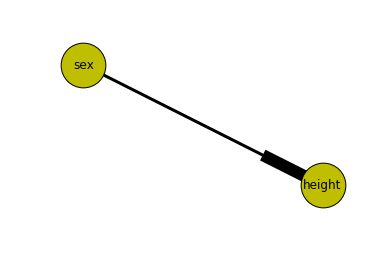

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx

G=nx.DiGraph()
G.add_edge('sex','height',weight=0.6)
nx.draw_networkx(G, node_color='y',node_size=2000, width=3)
plt.axis('off')
plt.show()

### Why is this a useful problem solving tool?

This can model a much more general set of Joint Probability Distributions than our student-height problem.  Do all possible graphs (given nodes) represent a useful model for for a JPD?

We can talk about classes of graphs that solve problems
* Bi-directional Graphs are Markov Models
* Directed Acyclic Graphs (DAGs) are called Baysian Models

We can use graphs for book keeping about distributions and dependencies

Practical models can have many nodes. Graphs models help us manage complexity.

We can state reasoning rules that are constent with the statistical assumptions that allow understand and transform nodes or groups of nodes.

## Some jobs we need to figure out how to do to make this practically useful

0. Ask questions about the probabilities represented by the model. _Inference_:
    * Causal Reasoning is looking for downstream effects of assumptions about parents. E.g. Given a male student, how likely is it he will be 165 cm in height?
    * Evidential Reasoning is looking for upstream effects of assumptions about childern. E.g. Give a height of 174 cm, what is probability that the student is female? 
    * Intercausal. Given to observations of a common cause, what can we say about the likelyhood of one of the cause measurements?

1. Learn parameters of a model given graph structure and representative data

2. Learn the structure of the graph given representative data

3. Build heuristics and rules by which we can reason about graphs. E.g. How to convert Bayese models to Markov models?  What sort of structures allow influence to propogate and which do not?

In [41]:
import numpy as np
import pandas as pd
import csv
import json

from libpgm.graphskeleton import GraphSkeleton
from libpgm.nodedata import NodeData
from libpgm.discretebayesiannetwork import DiscreteBayesianNetwork
from libpgm.tablecpdfactorization import TableCPDFactorization
from libpgm.pgmlearner import PGMLearner

## Let's look at some data

Survival data from Titanic based on age, sex and travel class.

In [42]:
titanic = pd.DataFrame.from_csv("./data/titanic3.csv", index_col = None)
print titanic.head()
print titanic.describe()

   pclass  survived                              name  sex  age
0       3         0               Abbing, Mr. Anthony    0   42
1       3         0     Abbott, Master. Eugene Joseph    0   13
2       3         0       Abbott, Mr. Rossmore Edward    0   16
3       3         1  Abbott, Mrs. Stanton (Rosa Hunt)    1   35
4       3         1       Abelseth, Miss. Karen Marie    1   16
            pclass     survived          sex          age
count  1045.000000  1045.000000  1045.000000  1045.000000
mean      2.208612     0.408612     0.371292    29.869538
std       0.841069     0.491813     0.483382    14.415518
min       1.000000     0.000000     0.000000     0.166700
25%       1.000000     0.000000     0.000000    21.000000
50%       2.000000     0.000000     0.000000    28.000000
75%       3.000000     1.000000     1.000000    39.000000
max       3.000000     1.000000     1.000000    80.000000


Summarize with a pivot table to see the kinds of distributions that maybe lurking in the data.

In [43]:
ptable = pd.pivot_table(titanic, values=["name"], columns=["survived", "pclass","sex"], aggfunc=lambda x: len(x.unique()), margins=True)
print ptable

      survived  pclass  sex
name  0         1       0        97
                        1         5
                2       0       135
                        1        11
                3       0       289
                        1        80
      1         1       0        53
                        1       128
                2       0        23
                        1        92
                3       0        59
                        1        72
      All                      1043
dtype: int64


In [44]:
# need to converst to node:value list for libpgm
with open("./data/titanic3.csv") as f:
    rdr = csv.reader(f, )
    headers = next(rdr, None)
    data = [{k:float(v) for k,v in zip(headers, row) if k !="name"} for row in rdr]
headers.remove("name")
#print data

## Learn Parameters of Graph Model give Data

{'Vdata': None, 'E': [['age', 'pclass'], ['sex', 'survived'], ['pclass', 'survived']], 'V': ['pclass', 'survived', 'sex', 'age']}


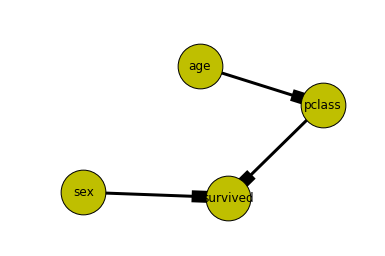

In [45]:
pgn = {
    "V": headers,
    "E": [["age", "pclass"],
        ["sex", "survived"],
         ["pclass", "survived"]],
    "Vdata": None }
print pgn
G=nx.DiGraph()
for f,t in pgn["E"]:
    G.add_edge(f,t)
nx.draw_networkx(G, node_color='y',node_size=2000, width=3)
plt.axis('off')
plt.show()

In [46]:
skel = GraphSkeleton()
skel.V = pgn["V"]
skel.E = pgn["E"]
skel.toporder()

learner = PGMLearner()
result = learner.discrete_mle_estimateparams(skel, data)

In [47]:
pd.DataFrame(result.Vdata["sex"]["cprob"]).transpose()

,0,1
0,0.628708,0.371292


In [48]:
pd.DataFrame(result.Vdata["pclass"]["cprob"]).transpose()

,0,1,2
['0.1667'],1.000000,0.000000,0.000000
['0.3333'],1.000000,0.000000,0.000000
['0.4167'],1.000000,0.000000,0.000000
['0.6667'],0.000000,1.000000,0.000000
['0.75'],1.000000,0.000000,0.000000
['0.8333'],0.333333,0.666667,0.000000
['0.9167'],0.000000,0.500000,0.500000
['1.0'],0.700000,0.300000,0.000000
['10.0'],1.000000,0.000000,0.000000
['11.0'],0.750000,0.000000,0.250000


## Causal Reasoning

In [49]:
nd = NodeData()
nd.Vdata = result.Vdata
nd.alldata = None
bn = DiscreteBayesianNetwork(skel, nd)

# query alters tables
tcpd = TableCPDFactorization(bn)
print tcpd.specificquery(dict(sex=[1]), dict())

tcpd = TableCPDFactorization(bn)
print tcpd.specificquery(dict(sex=[1]), dict(survived=1))

tcpd = TableCPDFactorization(bn)
print tcpd.specificquery(dict(sex=[0],pclass=[3.0]), dict(survived=0))

pd.pivot_table(titanic, values=["name"], columns=["sex", "pclass","survived"], aggfunc=lambda x: len(x.unique()))

0.371291866029
0.663292523186
0.415977933644


      sex  pclass  survived
name  0    1       0            97
                   1            53
           2       0           135
                   1            23
           3       0           289
                   1            59
      1    1       0             5
                   1           128
           2       0            11
                   1            92
           3       0            80
                   1            72
dtype: int64

## Learn Graph Structure

[
  [
    "age", 
    "pclass"
  ], 
  [
    "age", 
    "survived"
  ], 
  [
    "pclass", 
    "survived"
  ], 
  [
    "sex", 
    "survived"
  ]
]
[
  "sex", 
  "age", 
  "pclass", 
  "survived"
]


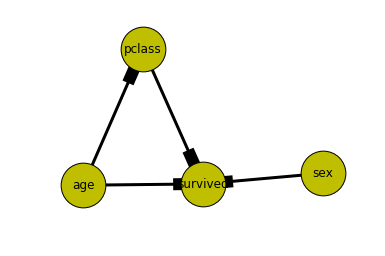

In [50]:
# instantiate my learner 
learner = PGMLearner()

# estimate structure
result = learner.lg_constraint_estimatestruct(data, indegree=1)

# output
print json.dumps(result.E, indent=2)
print json.dumps(result.V, indent=2)

G=nx.DiGraph()
for f,t in result.E:
    G.add_edge(f,t,weight=0.6)
nx.draw_networkx(G, node_color='y',node_size=2000, width=3)
plt.axis('off')
plt.show()

In [51]:
## different model, so learn new parameters

In [52]:
skel = GraphSkeleton()
skel.V = result.V
skel.E = result.E
skel.toporder()

learner = PGMLearner()
result = learner.discrete_mle_estimateparams(skel, data)

## Queries with New Model

In [55]:
nd = NodeData()
nd.Vdata = result.Vdata
nd.alldata = None
bn = DiscreteBayesianNetwork(skel, nd)

# query alters tables
tcpd = TableCPDFactorization(bn)
print tcpd.specificquery(dict(sex=[1]), dict())

tcpd = TableCPDFactorization(bn)
print tcpd.specificquery(dict(sex=[1]), dict(survived=1))

tcpd = TableCPDFactorization(bn)
print tcpd.specificquery(dict(sex=[0],pclass=[3.0]), dict(survived=0))

pd.pivot_table(titanic, values=["name"], columns=["sex", "pclass","survived"], aggfunc=lambda x: len(x.unique()))

0.371291866029
0.636917029612
0.408512668557


      sex  pclass  survived
name  0    1       0            97
                   1            53
           2       0           135
                   1            23
           3       0           289
                   1            59
      1    1       0             5
                   1           128
           2       0            11
                   1            92
           3       0            80
                   1            72
dtype: int64